## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# For fetching real financial data
import yfinance as yf

# Date handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Define the stocks we want to analyze
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
ticker_names = {
    'AAPL': 'Apple',
    'MSFT': 'Microsoft',
    'GOOGL': 'Google',
    'JPM': 'JPMorgan',
    'GS': 'Goldman Sachs'
}

# Set date range (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

# Download stock data
print("Downloading stock data...")
stock_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Handle MultiIndex columns from yfinance
# yfinance returns MultiIndex columns: (Price, Ticker)
if isinstance(stock_data.columns, pd.MultiIndex):
    # Get close prices (yfinance no longer provides Adj Close by default)
    prices = stock_data['Close'].copy()
    volume = stock_data['Volume'].copy()
else:
    # Single ticker case
    prices = stock_data[['Close']].copy()
    prices.columns = [tickers[0]]
    volume = stock_data[['Volume']].copy()
    volume.columns = [tickers[0]]

# Rename columns to company names
prices.columns = [ticker_names.get(col, col) for col in prices.columns]
volume.columns = [ticker_names.get(col, col) for col in volume.columns]

In [3]:
from pathlib import Path
import hashlib
import re
import warnings

import numpy as np
import pandas as pd

# ── Configuración general ──
CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)
warnings.filterwarnings("ignore")

# ── Helpers ──
_ES_TO_EN_MONTH = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

def _hash_key(*parts: str) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _normalize_period(code: str, period: str | None) -> str | None:
    if period is None:
        return None
    period = str(period).strip()
    freq = code[-2:].upper() if len(code) >= 2 else ""

    if freq in ["PD", "PM", "MD"]:
        if re.fullmatch(r"\d{4}-\d{1,2}", period):
            y, m = period.split("-")
            return f"{int(y):04d}-{int(m):02d}-01"
        if re.fullmatch(r"\d{4}", period):
            return f"{int(period):04d}-01-01"
        return period
    return period

def _parse_bcrp_period_name(name: str) -> pd.Timestamp:
    s = str(name).strip()
    # ISO-ish
    try:
        if re.fullmatch(r"\d{4}(-\d{1,2}){0,2}", s):
            return pd.to_datetime(s, errors="raise")
    except Exception:
        pass
    # Monthly like "Mar.2020"
    m = re.fullmatch(r"([A-Za-zÁÉÍÓÚÑñ]{3})\.(\d{4})", s)
    if m:
        mon_es, y = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        return pd.to_datetime(f"{mon}.{y}", format="%b.%Y", errors="coerce")
    # Daily like "18Nov25"
    m = re.fullmatch(r"(\d{2})([A-Za-zÁÉÍÓÚÑñ]{3})(\d{2})", s)
    if m:
        d, mon_es, yy = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        year = 2000 + int(yy) if int(yy) <= 69 else 1900 + int(yy)
        return pd.to_datetime(f"{d}{mon}{year}", format="%d%b%Y", errors="coerce")
    return pd.to_datetime(s, errors="coerce")

# ── Función principal para obtener series BCRP ──
def bcrp_get(series_codes, start: str | None = None, end: str | None = None, lang: str = "esp") -> pd.DataFrame:
    import requests

    if isinstance(series_codes, (list, tuple)):
        codes_list = [str(c).strip() for c in series_codes]
        codes = "-".join(codes_list)
        freq_code = codes_list[0]
    else:
        codes = str(series_codes).strip()
        codes_list = codes.split("-")
        freq_code = codes_list[0]

    start_n = _normalize_period(freq_code, start)
    end_n = _normalize_period(freq_code, end)

    key = _hash_key("bcrp", codes, start_n or "", end_n or "", lang)
    cache_path = CACHE_DIR / f"bcrp_{key}.pkl"
    if cache_path.exists():
        return pd.read_pickle(cache_path)

    base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
    parts = [base_url, codes, "json"]
    if start_n and end_n:
        parts += [start_n, end_n]
    if lang:
        parts += [lang]
    url = "/".join(parts)

    r = requests.get(url, timeout=30)
    r.raise_for_status()
    obj = r.json()

    periods = obj.get("periods", [])
    rows = []
    for p in periods:
        name = p.get("name")
        vals = p.get("values", [])
        if isinstance(vals, str):
            vals = [vals]
        if name is None or not isinstance(vals, list):
            continue
        vals = (vals + [None] * len(codes_list))[:len(codes_list)]
        rows.append([name] + vals)

    df = pd.DataFrame(rows, columns=["date"] + codes_list)
    if df.shape[0] == 0:
        return pd.DataFrame(columns=["date"] + codes_list)

    df["date"] = df["date"].apply(_parse_bcrp_period_name)
    for c in codes_list:
        df[c] = df[c].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan})
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    df.to_pickle(cache_path)
    return df

def bcrp_get_cached_or_empty(series_codes, start: str, end: str) -> pd.DataFrame:
    try:
        return bcrp_get(series_codes, start=start, end=end)
    except Exception:
        if isinstance(series_codes, (list, tuple)):
            codes_list = [str(c).strip() for c in series_codes]
        else:
            codes_list = [str(series_codes).strip()]
        return pd.DataFrame(columns=["date"] + codes_list)


1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [7]:
series_bcrp = ["PD04637PD","PD04639PD","PD04704XD","PD04701XD"]

df_bcrp = bcrp_get(series_codes=series_bcrp,start="2015-01-01",end="2024-12-31",lang="esp")

df_bcrp.head()

,date,PD04637PD,PD04639PD,PD04704XD,PD04701XD
0,2015-02-02,3.06,3.06,251.09,1272.50
1,2015-02-03,3.06,3.06,258.32,1264.25
2,2015-02-04,3.06,3.06,258.91,1268.50
3,2015-02-05,3.06,3.06,253.78,1259.25
4,2015-02-06,3.07,3.06,258.18,1241.00


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [8]:
df_tidy = (df_bcrp.melt(id_vars="date",var_name="series",value_name="value")
          .dropna(subset=["value"]).sort_values(["series", "date"]).reset_index(drop=True))

df_tidy.head(10)

,date,series,value
0,2015-02-02,PD04637PD,3.06
1,2015-02-03,PD04637PD,3.06
2,2015-02-04,PD04637PD,3.06
3,2015-02-05,PD04637PD,3.06
4,2015-02-06,PD04637PD,3.07
5,2015-02-09,PD04637PD,3.06
6,2015-02-10,PD04637PD,3.07
7,2015-02-11,PD04637PD,3.09
8,2015-02-12,PD04637PD,3.08
9,2015-02-13,PD04637PD,3.07


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [9]:
series_map = {"PD04637PD": "fx_interbank","PD04639PD": "fx_sbs",
              "PD04704XD": "gold","PD04701XD": "copper"}

df_wide = (df_tidy.assign(series=lambda x: x["series"].map(series_map))
                  .dropna(subset=["series"])
                  .pivot(index="date", columns="series", values="value")
                  .sort_index()
                  .reset_index())

df_wide = df_wide[["date", "fx_interbank", "fx_sbs", "gold", "copper"]]

print(df_wide)

series       date  fx_interbank  fx_sbs   gold  copper
0      2015-02-02          3.06    3.06 251.09 1272.50
1      2015-02-03          3.06    3.06 258.32 1264.25
2      2015-02-04          3.06    3.06 258.91 1268.50
3      2015-02-05          3.06    3.06 253.78 1259.25
4      2015-02-06          3.07    3.06 258.18 1241.00
...           ...           ...     ...    ...     ...
1514   2024-11-25          3.77    3.77 404.51 2625.01
1515   2024-11-26          3.77    3.77 404.83 2633.15
1516   2024-11-27          3.75    3.75 403.58 2636.02
1517   2024-11-28          3.75    3.74 401.45 2637.92
1518   2024-11-29          3.74    3.74 402.74 2643.15

[1519 rows x 5 columns]


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [10]:
START = "2021-01-01"
END = "2025-12-18"

tickers = ["SPY", "TLT", "GLD"]

prices = yf.download(tickers,start=START,end=END,auto_adjust=True,progress=False)

df_tidy = (prices["Close"].reset_index().melt(id_vars="Date",
                                              var_name="ticker",
                                              value_name="close").rename(columns={"Date": "date"})
                                                                 .dropna(subset=["close"])
                                                                 .sort_values(["ticker", "date"])
                                                                 .reset_index(drop=True))

df_tidy.head(10)

,date,ticker,close
0,2021-01-04,GLD,182.33
1,2021-01-05,GLD,182.87
2,2021-01-06,GLD,179.90
3,2021-01-07,GLD,179.48
4,2021-01-08,GLD,173.34
5,2021-01-11,GLD,173.00
6,2021-01-12,GLD,174.12
7,2021-01-13,GLD,173.37
8,2021-01-14,GLD,173.28
9,2021-01-15,GLD,171.13


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [11]:
df_ret = (
    df_tidy
    .sort_values(["ticker", "date"])
    .assign(
        ret=lambda x: x.groupby("ticker")["close"].pct_change()
    )
)

import numpy as np

df_ret["ret"] = df_ret["ret"].replace([np.inf, -np.inf], np.nan)
df_ret = df_ret.dropna(subset=["ret"])

assert not np.isinf(df_ret["ret"]).any(), "There are inf values in returns"

df_ret.head()

,date,ticker,close,ret
1,2021-01-05,GLD,182.87,0.00
2,2021-01-06,GLD,179.90,-0.02
3,2021-01-07,GLD,179.48,-0.00
4,2021-01-08,GLD,173.34,-0.03
5,2021-01-11,GLD,173.00,-0.00


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


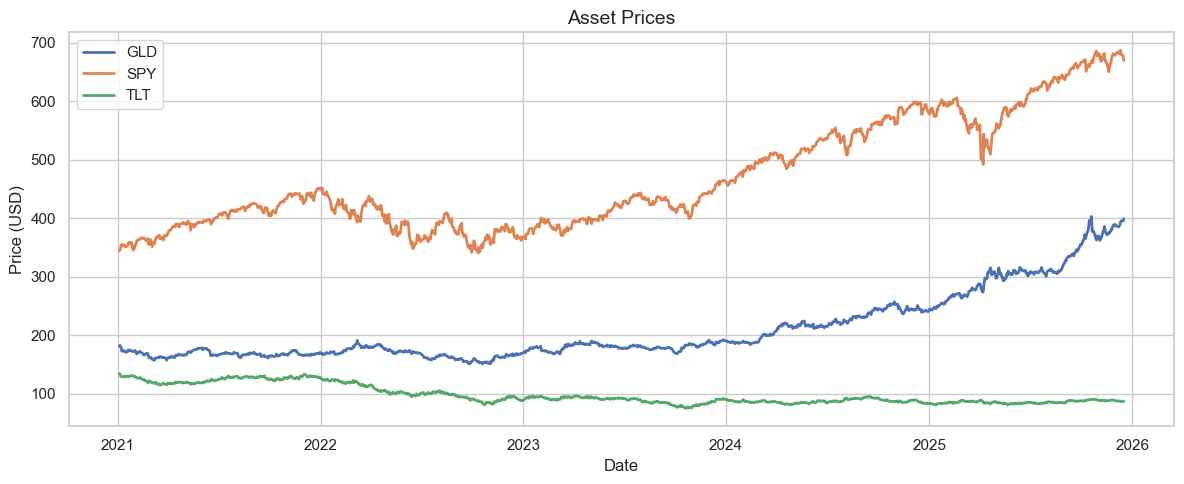

In [12]:
# Ensure datetime
df_tidy["date"] = pd.to_datetime(df_tidy["date"])

# Style
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 5))

# Plot each ticker
for ticker, g in df_tidy.groupby("ticker"):
    ax.plot(g["date"], g["close"], label=ticker, linewidth=2)

# Title and labels
ax.set_title("Asset Prices", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")

# Date formatting
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)

# Legend
ax.legend()

plt.tight_layout()
plt.show()

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [13]:
# Crear columna booleana: True si retorno > 0
df_ret["positive"] = df_ret["ret"] > 0

positive_share = (
    df_ret
    .groupby("ticker")["positive"]
    .mean()  # La media de True/False = proporción
    .reset_index()
    .rename(columns={"positive": "share_positive_days"})
)

positive_share

,ticker,share_positive_days
0,GLD,0.54
1,SPY,0.55
2,TLT,0.49


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


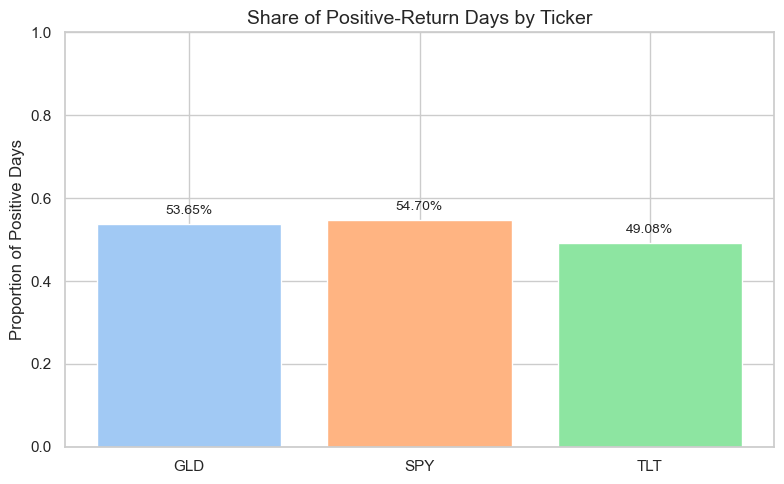

In [14]:
# Estilo seaborn
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 5))

# Bar chart
bars = ax.bar(
    positive_share["ticker"],
    positive_share["share_positive_days"],
    color=sns.color_palette("pastel", len(positive_share))
)

# Etiquetas arriba de cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height:.2%}',           # Formato porcentaje
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),             # 5 puntos vertical offset
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Título y etiquetas
ax.set_title("Share of Positive-Return Days by Ticker", fontsize=14)
ax.set_ylabel("Proportion of Positive Days")
ax.set_ylim(0, 1)  # asegurar que y esté entre 0 y 1

plt.tight_layout()
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


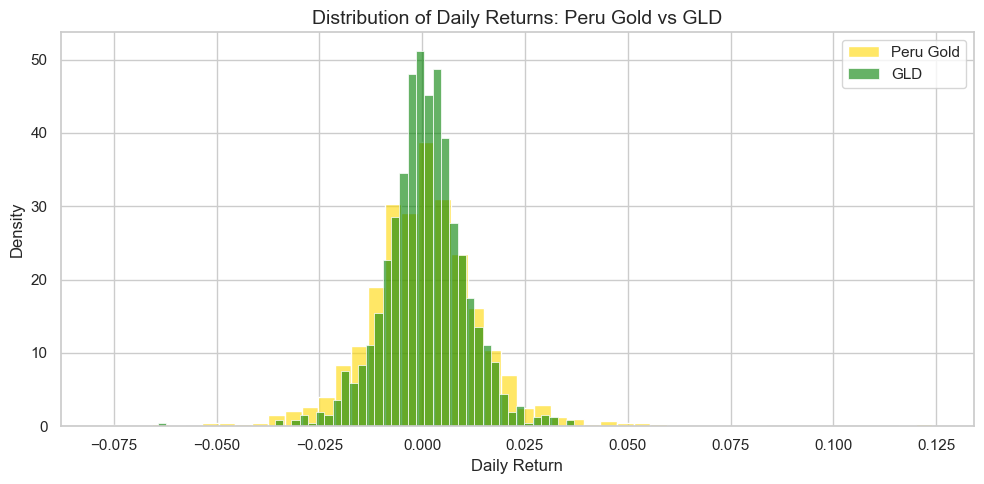

In [15]:
# Peru Gold daily returns
gold_ret = df_wide["gold"].pct_change().dropna()

# GLD daily returns
gld_ret = df_ret[df_ret["ticker"]=="GLD"]["ret"].dropna()

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))

# Histograma Peru Gold
sns.histplot(gold_ret, bins=50, color="gold", label="Peru Gold", alpha=0.6, stat="density", ax=ax)

# Histograma GLD
sns.histplot(gld_ret, bins=50, color="green", label="GLD", alpha=0.6, stat="density", ax=ax)

# Título y etiquetas
ax.set_title("Distribution of Daily Returns: Peru Gold vs GLD", fontsize=14)
ax.set_xlabel("Daily Return")
ax.set_ylabel("Density")

# Leyenda
ax.legend()

plt.tight_layout()
plt.show()

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


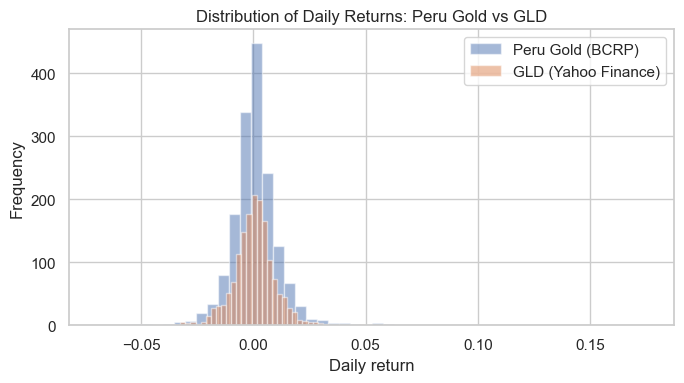

Observaciones comunes: 1615
Std Peru Gold: 0.01237017829712817
Std GLD: 0.009572939582593119


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests

START = "2015-01-01"
END   = "2025-12-31"
BCRP_GOLD_CODE = "PD04704XD"  # Oro Perú (BCRP)

# 1) Descargar Oro Perú (BCRP)
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{BCRP_GOLD_CODE}/json/{START}/{END}"
r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()

gold_pe = pd.DataFrame(data["periods"]).rename(columns={"name": "date"})

# el BCRP suele traer 'values' (lista). Tomamos el primer valor.
if "values" in gold_pe.columns:
    gold_pe["gold"] = gold_pe["values"].apply(
        lambda v: v[0] if isinstance(v, list) and len(v) > 0 else np.nan
    )
elif "value" in gold_pe.columns:  # por si acaso viene como 'value'
    gold_pe["gold"] = gold_pe["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value' en periods. Columnas: {gold_pe.columns.tolist()}")

gold_pe["date"] = pd.to_datetime(gold_pe["date"], errors="coerce")
gold_pe["gold"] = pd.to_numeric(gold_pe["gold"], errors="coerce")
gold_pe = gold_pe.dropna(subset=["date", "gold"]).sort_values("date")

gold_pe_ret = gold_pe.set_index("date")["gold"].pct_change().dropna()

# 2) Descargar GLD (Yahoo Finance) y retornos
gld = yf.download("GLD", start=START, end=END, auto_adjust=True, progress=False)
gld_ret = gld["Close"].pct_change().dropna()

# 3) Alinear fechas comunes
common_dates = gold_pe_ret.index.intersection(gld_ret.index)
gold_pe_ret = gold_pe_ret.loc[common_dates]
gld_ret = gld_ret.loc[common_dates]

# 4) Histograma comparativo
plt.figure(figsize=(7,4))
plt.hist(gold_pe_ret, bins=50, alpha=0.5, label="Peru Gold (BCRP)")
plt.hist(gld_ret, bins=50, alpha=0.5, label="GLD (Yahoo Finance)")
plt.title("Distribution of Daily Returns: Peru Gold vs GLD")
plt.xlabel("Daily return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

print("Observaciones comunes:", len(common_dates))
print("Std Peru Gold:", float(gold_pe_ret.std()))
print("Std GLD:", float(gld_ret.std()))

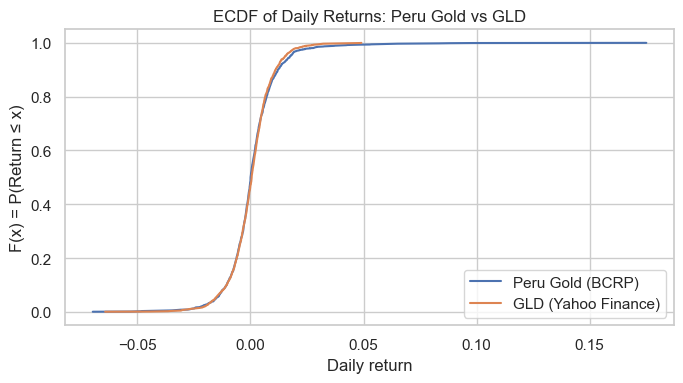

Comentario (ECDF vs Histograma):
- La ECDF NO depende de 'bins' (a diferencia del histograma).
- Permite leer percentiles directamente: por ejemplo, el VaR 95% ≈ percentil 5%.
- Diferencias en colas se ven como separaciones claras en la parte baja (izquierda) de la curva.
Obs comunes: 1615


In [18]:
START = "2015-01-01"
END   = "2025-12-31"
BCRP_GOLD_CODE = "PD04704XD"  # Oro Perú (BCRP)

# ---- 1) Descargar Oro Perú (BCRP) y retornos ----
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{BCRP_GOLD_CODE}/json/{START}/{END}"
r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()

gold_pe = pd.DataFrame(data["periods"]).rename(columns={"name":"date"})

if "values" in gold_pe.columns:
    gold_pe["gold"] = gold_pe["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
elif "value" in gold_pe.columns:
    gold_pe["gold"] = gold_pe["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {gold_pe.columns.tolist()}")

gold_pe["date"] = pd.to_datetime(gold_pe["date"], errors="coerce")
gold_pe["gold"] = pd.to_numeric(gold_pe["gold"], errors="coerce")
gold_pe = gold_pe.dropna(subset=["date","gold"]).sort_values("date")

gold_pe_ret = gold_pe.set_index("date")["gold"].pct_change().dropna()

# ---- 2) Descargar GLD (Yahoo) y retornos ----
gld = yf.download("GLD", start=START, end=END, auto_adjust=True, progress=False)
gld_ret = gld["Close"].pct_change().dropna()

# ---- 3) Alinear fechas ----
common = gold_pe_ret.index.intersection(gld_ret.index)
gold_pe_ret = gold_pe_ret.loc[common]
gld_ret = gld_ret.loc[common]

# ---- 4) ECDF function ----
def ecdf(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y

x_pe, y_pe = ecdf(gold_pe_ret.values)
x_gld, y_gld = ecdf(gld_ret.values)

# ---- 5) Plot ECDF ----
plt.figure(figsize=(7,4))
plt.plot(x_pe, y_pe, label="Peru Gold (BCRP)")
plt.plot(x_gld, y_gld, label="GLD (Yahoo Finance)")
plt.title("ECDF of Daily Returns: Peru Gold vs GLD")
plt.xlabel("Daily return")
plt.ylabel("F(x) = P(Return ≤ x)")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 6) Comentario automático (para tu notebook) ----
print("Comentario (ECDF vs Histograma):")
print("- La ECDF NO depende de 'bins' (a diferencia del histograma).")
print("- Permite leer percentiles directamente: por ejemplo, el VaR 95% ≈ percentil 5%.")
print("- Diferencias en colas se ven como separaciones claras en la parte baja (izquierda) de la curva.")
print("Obs comunes:", len(common))

11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


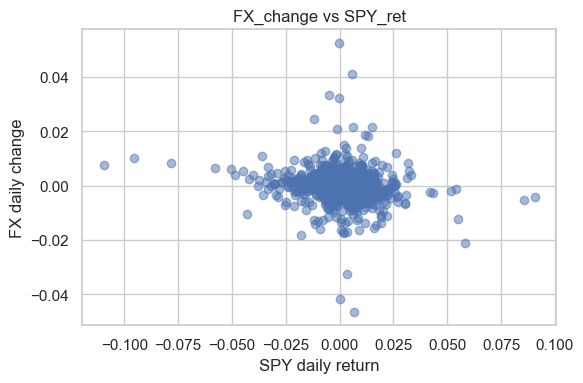

Observaciones usadas: 1554


In [19]:
START = "2015-01-01"
END   = "2025-12-31"

FX_CODE = "PD04637PD"   # FX Interbank
SPY_TICKER = "SPY"

# ---- 1) Descargar FX (BCRP) ----
url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
r = requests.get(url_fx, timeout=30)
r.raise_for_status()
obj = r.json()

fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})

if "values" in fx.columns:
    fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v) > 0 else np.nan)
elif "value" in fx.columns:
    fx["fx"] = fx["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
fx = fx.dropna(subset=["date", "fx"]).sort_values("date")

# FX_change = retorno diario del tipo de cambio
fx["FX_change"] = fx["fx"].pct_change()

# ---- 2) Descargar SPY (Yahoo Finance) ----
spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)

# Extraer Close de forma robusta (Series)
close = spy["Close"]
if isinstance(close, pd.DataFrame):          # por si Close viene como DF
    close = close.iloc[:, 0]                # tomar primera columna

spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
spy_ret.index.name = "date"
spy_ret = spy_ret.reset_index()

# ---- 3) Merge por fechas ----
merged = (
    fx[["date", "FX_change"]]
    .merge(spy_ret, on="date", how="inner")
    .dropna()
)

# ---- 4) Scatter plot ----
plt.figure(figsize=(6,4))
plt.scatter(merged["SPY_ret"], merged["FX_change"], alpha=0.5)
plt.title("FX_change vs SPY_ret")
plt.xlabel("SPY daily return")
plt.ylabel("FX daily change")
plt.tight_layout()
plt.show()

print("Observaciones usadas:", len(merged))


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [20]:
START = "2015-01-01"
END   = "2025-12-31"

FX_CODE = "PD04637PD"   # FX Interbank (Perú)
SPY_TICKER = "SPY"

# ---- 1) FX (BCRP) ----
url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
r = requests.get(url_fx, timeout=30)
r.raise_for_status()
obj = r.json()

fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})
if "values" in fx.columns:
    fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
elif "value" in fx.columns:
    fx["fx"] = fx["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
fx = fx.dropna(subset=["date","fx"]).sort_values("date")
fx["FX_change"] = fx["fx"].pct_change()

# ---- 2) SPY (Yahoo) ----
spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)
close = spy["Close"]
if isinstance(close, pd.DataFrame):
    close = close.iloc[:, 0]
spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
spy_ret.index.name = "date"

# ---- 3) Merge ----
merged = (
    fx[["date","FX_change"]]
    .merge(spy_ret.reset_index(), on="date", how="inner")
    .dropna()
)

# ---- 4) Correlación ----
corr = merged["FX_change"].corr(merged["SPY_ret"])
print(f"Correlation(FX_change, SPY_ret) = {corr:.4f}")

# ---- 5) Interpretación automática ----
if corr < 0:
    print("Interpretación: correlación NEGATIVA.")
    print("- Cuando SPY sube, el sol tiende a apreciarse (FX_change < 0).")
    print("- Consistente con mayor apetito por riesgo y entradas de capital.")
elif corr > 0:
    print("Interpretación: correlación POSITIVA.")
    print("- Cuando SPY cae, el tipo de cambio tiende a subir (depreciación del sol).")
    print("- Consistente con flight-to-safety.")
else:
    print("Interpretación: correlación cercana a cero (relación lineal débil).")

print("Observaciones usadas:", len(merged))


Correlation(FX_change, SPY_ret) = -0.1643
Interpretación: correlación NEGATIVA.
- Cuando SPY sube, el sol tiende a apreciarse (FX_change < 0).
- Consistente con mayor apetito por riesgo y entradas de capital.
Observaciones usadas: 1554


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [22]:
import statsmodels.api as sm

START = "2015-01-01"
END   = "2025-12-31"

FX_CODE = "PD04637PD"   # FX Interbank (Perú)
SPY_TICKER = "SPY"

# ---- 1) FX (BCRP) ----
url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
r = requests.get(url_fx, timeout=30)
r.raise_for_status()
obj = r.json()

fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})
if "values" in fx.columns:
    fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
elif "value" in fx.columns:
    fx["fx"] = fx["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
fx = fx.dropna(subset=["date","fx"]).sort_values("date")
fx["FX_change"] = fx["fx"].pct_change()

# ---- 2) SPY (Yahoo) ----
spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)
close = spy["Close"]
if isinstance(close, pd.DataFrame):
    close = close.iloc[:, 0]
spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
spy_ret.index.name = "date"

# ---- 3) Merge ----
merged = (
    fx[["date","FX_change"]]
    .merge(spy_ret.reset_index(), on="date", how="inner")
    .dropna()
)

# ---- 4) Regresión OLS ----
X = sm.add_constant(merged["SPY_ret"])  # agrega intercepto
y = merged["FX_change"]

model = sm.OLS(y, X).fit()
print(model.summary())

# ---- 5) Interpretación automática del coeficiente ----
beta = model.params["SPY_ret"]
alpha = model.params["const"]

print("\nInterpretación:")
print(f"- Intercepto (alpha): {alpha:.6f}")
print(f"- Pendiente (beta): {beta:.4f}")

if beta < 0:
    print("→ Un aumento de 1% en el SPY se asocia con una APRECIACIÓN del sol (FX_change negativo).")
elif beta > 0:
    print("→ Un aumento de 1% en el SPY se asocia con una DEPRECIACIÓN del sol (FX_change positivo).")
else:
    print("→ No hay relación lineal apreciable.")

print("Observaciones usadas:", len(merged))

                            OLS Regression Results                            
Dep. Variable:              FX_change   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     43.08
Date:                Fri, 09 Jan 2026   Prob (F-statistic):           7.13e-11
Time:                        15:47:09   Log-Likelihood:                 6089.7
No. Observations:                1554   AIC:                        -1.218e+04
Df Residuals:                    1552   BIC:                        -1.216e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      1.029      0.3

14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [23]:
# --- Si no existe merged, lo construimos rápido (como en punto 11) ---
if "merged" not in globals() or not isinstance(globals()["merged"], pd.DataFrame):
    START = "2015-01-01"
    END   = "2025-12-31"
    FX_CODE = "PD04637PD"
    SPY_TICKER = "SPY"

    # FX BCRP
    url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
    r = requests.get(url_fx, timeout=30)
    r.raise_for_status()
    obj = r.json()

    fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})
    if "values" in fx.columns:
        fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
    elif "value" in fx.columns:
        fx["fx"] = fx["value"]
    else:
        raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

    fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
    fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
    fx = fx.dropna(subset=["date","fx"]).sort_values("date")
    fx["FX_change"] = fx["fx"].pct_change()

    # SPY Yahoo
    spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)
    close = spy["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
    spy_ret.index.name = "date"

    merged = (
        fx[["date","FX_change"]]
        .merge(spy_ret.reset_index(), on="date", how="inner")
        .dropna()
    )

# ----------------------------
# A) .iloc  (posición)
# ----------------------------
print("A) Ejemplo .iloc (por posición): primeras 5 filas y 2 columnas (date y FX_change)")
print(merged.iloc[:5, :2])   # filas 0-4, columnas 0-1

# ----------------------------
# B) Conditional filtering (condición)
# ----------------------------
print("\nB) Ejemplo de filtro condicional: días donde SPY_ret > 2%")
big_spy = merged[merged["SPY_ret"] > 0.02]  # 2% = 0.02
print(big_spy.head())

print("\nCantidad de días con SPY_ret > 2%:", len(big_spy))

# ----------------------------
# Explicación breve
# ----------------------------
print("\nExplicación:")
print("- .iloc selecciona por POSICIÓN (índices numéricos). No le importa el contenido.")
print("- El filtrado condicional selecciona por REGLA (por ejemplo: retornos > 2%).")
print("- En finanzas, el filtro condicional se usa para eventos (colas, shocks), mientras .iloc sirve para slicing/muestreo.")

A) Ejemplo .iloc (por posición): primeras 5 filas y 2 columnas (date y FX_change)
        date  FX_change
1 2015-02-03      -0.00
2 2015-02-04       0.00
3 2015-02-05      -0.00
4 2015-02-06       0.00
5 2015-02-09      -0.00

B) Ejemplo de filtro condicional: días donde SPY_ret > 2%
          date  FX_change  SPY_ret
149 2016-02-12      -0.00     0.02
160 2016-03-01      -0.00     0.02
265 2016-11-07      -0.00     0.02
459 2018-03-26      -0.01     0.03
533 2018-10-16      -0.00     0.02

Cantidad de días con SPY_ret > 2%: 45

Explicación:
- .iloc selecciona por POSICIÓN (índices numéricos). No le importa el contenido.
- El filtrado condicional selecciona por REGLA (por ejemplo: retornos > 2%).
- En finanzas, el filtro condicional se usa para eventos (colas, shocks), mientras .iloc sirve para slicing/muestreo.


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.
